# Spam Detection for Imbalanced Data Using Random Sampling (SMOTE)

# Importing required packages

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PowerTransformer, OrdinalEncoder, LabelEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.stem import PorterStemmer
import nltk
from sklearn.neighbors import KNeighborsClassifier
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import time

# Data Cleaning

In [2]:
# Creating pandas dataframe of spam_1.csv using read_csv method.
df = pd.read_csv('spam_1.csv', low_memory=False)

In [3]:
# Dropping unnecessary columns from dataframe
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

In [4]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# checking the dimensions of pandas dataframe.
df.shape

(5572, 2)

In [6]:
# Checking null values.
null_counts = df.isnull().sum()
print(null_counts)

v1    0
v2    0
dtype: int64


In [7]:
# checking duplicates values.
dup_rows = df.duplicated().sum()
print(f"dup rows: {dup_rows}")

dup rows: 409


In [8]:
# dropping duplicate rows.
df = df.drop_duplicates()

In [9]:
df.shape

(5163, 2)

In [10]:
# Checking if dataset is balanced or not.
spam_counts = df['v1'].value_counts()

print("No of 0 (Non-Spam):", spam_counts.iloc[0])
print("No of 1 (Spam):", spam_counts.iloc[1])

No of 0 (Non-Spam): 4516
No of 1 (Spam): 647


# EDA

EDA 1: Bar Plot for No. of Spam/Non-spams

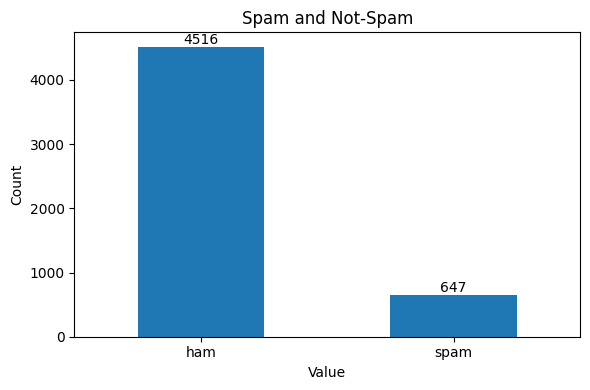

In [11]:
value_counts = df['v1'].value_counts()

plt.figure(figsize=(6, 4))
value_counts.plot(kind='bar')
plt.title('Spam and Not-Spam')
plt.xlabel('Value')
plt.ylabel('Count')
plt.xticks(rotation=0)

for i, count in enumerate(value_counts):
   plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [12]:
# Converting target values (ham and spam) into binary format(0,1).
le = LabelEncoder()
df['v1'] = le.fit_transform(df['v1'])

# Preprocessing

Preprocessing 1: Lower case

In [13]:
# Converting text into lower case 
df['v2'] = df['v2'].str.lower()

Preprocessing 2: De-contractions Words

In [14]:
# Defining contractions dataset.
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [15]:
# Function to decontract words.
def contr_words(text, contractions_dict):
    text = str(text)
    for contraction, expansion in contractions_dict.items():
        text = re.sub(r'\b' + re.escape(contraction) + r'\b', expansion, text, flags=re.IGNORECASE)
    return text

In [16]:
df['v2'] = df['v2'].apply(lambda x: contr_words(x, contractions))

Preprocessing 3: Removing Special Characters

In [17]:
# Removing special Characters using regex expression.
df['v2'] = df['v2'].str.replace(r'[^\w\s]', '', regex=True)

Preprocessing 4: Removing Stopwords

In [18]:
# downloading required packages to remove stopwords
nltk.download('stopwords')
nltk.download('punkt')
english_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
# Function to remove stopwords.
def remove_stopwords(text):
    tokens = word_tokenize(text.lower())  
    tokens_wo_stopwords = [word for word in tokens if word not in english_stopwords] 
    return ' '.join(tokens_wo_stopwords)

In [20]:
df['v2'] = df['v2'].apply(remove_stopwords)

Preprocessing 5: Stemming

In [21]:
# Implementing stemming using nltk - PorterStemmer module.
ps = PorterStemmer()

def stem_text(text):
    words = str(text).lower().split()
    stemmed_words = [ps.stem(word) for word in words]
    return ' '.join(stemmed_words)

In [22]:
df['v2'] = df['v2'].apply(stem_text)

# Feature Engineering

In [23]:
# Function to count number of words in a text.
def count_total_words(text):
    return len(word_tokenize(text))

In [24]:
df['num_words'] = df['v2'].apply(count_total_words)

In [25]:
df.head()

,v1,v2,num_words
0,0,go jurong point crazi avail bugi n great world...,16
1,0,ok lar joke wif u oni,6
2,1,free entri 2 wkli comp win fa cup final tkt 21...,23
3,0,u dun say earli hor u c alreadi say,9
4,0,nah think goe usf live around though,7


# Bag of Words

In [26]:
# Implementing Bag of words using TfidVectorizer.
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=4000,
    lowercase=True,
)
bow_matrix = vectorizer.fit_transform(df['v2'])
feature_names = vectorizer.get_feature_names_out()

In [27]:
bow_matrix.shape

(5163, 4000)

In [28]:
# Converting bag of word matrix back to pandas dataframe
bow_matrix_df = pd.DataFrame(bow_matrix.toarray())

In [29]:
num_w_df = pd.DataFrame(df['num_words'])

In [30]:
num_w_df.shape

(5163, 1)

In [31]:
# Merging bow_matrix and no of words to single dataframe.
bow_matrix_df = bow_matrix_df.reset_index(drop=True)
num_w_df = num_w_df.reset_index(drop=True)
final_df = pd.concat([bow_matrix_df, num_w_df], axis=1)

In [32]:
final_df = final_df.rename(str, axis="columns") 

In [33]:
final_df.shape

(5163, 4001)

# Train, Test and Split

In [34]:
# Spliting X and Y (target) variables.
X = final_df
y = df['v1']

In [35]:
# Spliting train and test data by 80:20 ratio.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Random sampling to handle imbalanced dataset <br>
SMOTE reduced the Accuracy of all models. But it improves the results of Spam detection than previous models.

In [ ]:
import sys
!{sys.executable} -m pip install imblearn

In [37]:
# Importing required modules for Random Sampling to handle imbalanced dataset.
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

SMOTE: It creates synthetic samples of minority(Spam) classes equals to majority(Non-spam) classes.

In [38]:
smote = SMOTE(
    sampling_strategy='auto', 
    random_state=42,
    k_neighbors=5  
)

In [39]:
X_sampled, y_sampled = smote.fit_resample(X_train, y_train)

In [40]:
resampled_spam_counts = pd.Series(y_sampled).value_counts()
print("No of 0 (Non-Spam):", resampled_spam_counts.iloc[0])
print("No of 1 (Spam):", resampled_spam_counts.iloc[1])
print("Ratio of Non-Spam to Spam:", resampled_spam_counts.iloc[0] / resampled_spam_counts.iloc[1])

No of 0 (Non-Spam): 3599
No of 1 (Spam): 3599
Ratio of Non-Spam to Spam: 1.0


# Model 1: Gradient Boosting

In [41]:
gb_classifier_resampled = GradientBoostingClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=3, 
    random_state=42,
)

In [42]:
start_time = time.time()
gb_classifier_resampled.fit(X_sampled, y_sampled)
gb_training_time = time.time() - start_time

In [43]:
gb_pred_resampled = gb_classifier_resampled.predict(X_test)
print("Accuracy :", accuracy_score(y_test, gb_pred_resampled))
print("Training Time: {:.4f} seconds".format(gb_training_time))

Accuracy : 0.9486931268151017
Training Time: 13.9185 seconds


# Model 2: KNN

In [44]:
knn_classifier = KNeighborsClassifier(n_neighbors=5, weights='distance')
start_time = time.time()
knn_classifier.fit(X_sampled, y_sampled)
knn_training_time = time.time() - start_time
knn_pred = knn_classifier.predict(X_test)

In [45]:
print("Accuracy:", accuracy_score(y_test, knn_pred))
print("KNN Training Time: {:.4f} seconds".format(knn_training_time))

Accuracy: 0.42110358180058083
KNN Training Time: 0.1494 seconds


# Model 3: Random Forest

In [46]:
rf_classifier = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    class_weight='balanced'
)

start_time = time.time()
rf_classifier.fit(X_sampled, y_sampled)
rf_training_time = time.time() - start_time
rf_pred = rf_classifier.predict(X_test)

In [47]:
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("RF Training Time: {:.4f} seconds".format(rf_training_time))

Accuracy: 0.9738625363020329
RF Training Time: 3.0933 seconds


# Extracting Models

In [48]:
import joblib

joblib.dump(rf_classifier, 'rf_model.joblib')
joblib.dump(vectorizer, 'spam_vectorizer.joblib')
joblib.dump(gb_classifier_resampled, 'gb_model.joblib')
joblib.dump(knn_classifier, 'knn_model.joblib')

['knn_model.joblib']

In [49]:
def predict_spam(text, contractions):
    loaded_model = joblib.load('knn_model.joblib')
    loaded_vectorizer = joblib.load('spam_vectorizer.joblib')
    
    text = text.lower()
    
    for contraction, expansion in contractions.items():
        text = re.sub(r'\b' + re.escape(contraction) + r'\b', expansion, text, flags=re.IGNORECASE)
    
    text = re.sub(r'[^\w\s]', '', text)

    tokens = word_tokenize(text.lower())
    english_stopwords = set(stopwords.words('english'))
    tokens_wo_stopwords = [word for word in tokens if word not in english_stopwords]
    text = ' '.join(tokens_wo_stopwords)
    
    ps = PorterStemmer()
    words = text.lower().split()
    stemmed_words = [ps.stem(word) for word in words]
    text = ' '.join(stemmed_words)
    
    num_words = len(word_tokenize(text))
    
    bow_matrix = loaded_vectorizer.transform([text])
    
    input_features = pd.DataFrame(bow_matrix.toarray())
    input_features['num_words'] = num_words
    input_features = input_features.rename(str, axis="columns")
    
    prediction = loaded_model.predict(input_features)
    
    return "Spam" if prediction[0] == 1 else "Not Spam"

In [50]:
print(predict_spam("Free prize! Click here to claim now!", contractions))

Spam


In [51]:
print(predict_spam("Hi, how are you doing today?", contractions))

Not Spam


In [52]:
print(predict_spam("Free iPhone! Click here to claim your prize now!", contractions))

Spam
